In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/RedesNeuronales/TP2/PhC-C2DH-U373.zip

Archive:  drive/MyDrive/RedesNeuronales/TP2/PhC-C2DH-U373.zip
   creating: PhC-C2DH-U373/
   creating: PhC-C2DH-U373/01/
  inflating: PhC-C2DH-U373/01/t000.tif  
  inflating: PhC-C2DH-U373/01/t001.tif  
  inflating: PhC-C2DH-U373/01/t002.tif  
  inflating: PhC-C2DH-U373/01/t003.tif  
  inflating: PhC-C2DH-U373/01/t004.tif  
  inflating: PhC-C2DH-U373/01/t005.tif  
  inflating: PhC-C2DH-U373/01/t006.tif  
  inflating: PhC-C2DH-U373/01/t007.tif  
  inflating: PhC-C2DH-U373/01/t008.tif  
  inflating: PhC-C2DH-U373/01/t009.tif  
  inflating: PhC-C2DH-U373/01/t010.tif  
  inflating: PhC-C2DH-U373/01/t011.tif  
  inflating: PhC-C2DH-U373/01/t012.tif  
  inflating: PhC-C2DH-U373/01/t013.tif  
  inflating: PhC-C2DH-U373/01/t014.tif  
  inflating: PhC-C2DH-U373/01/t015.tif  
  inflating: PhC-C2DH-U373/01/t016.tif  
  inflating: PhC-C2DH-U373/01/t017.tif  
  inflating: PhC-C2DH-U373/01/t018.tif  
  inflating: PhC-C2DH-U373/01/t019.tif  
  inflating: PhC-C2DH-U373/01/t020.tif  
  inflating: PhC-C

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [4]:
from PIL import Image

# Cargo Train y Val

Train será aumentado

In [5]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [6]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [7]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Imágenes de train sin aumentar

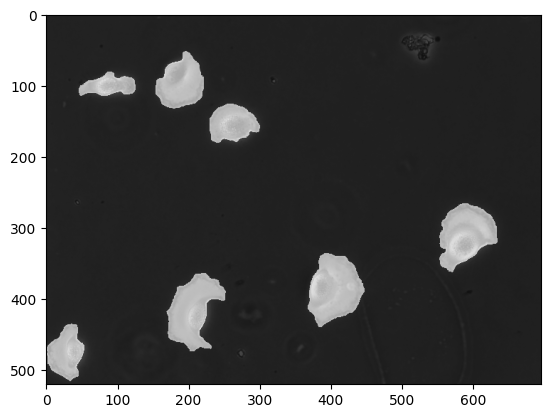

In [ ]:
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.6)
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [8]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)

In [9]:
x_train[0,:,:,0].max()

0.7254901960784313

In [ ]:
len(x_train)

115

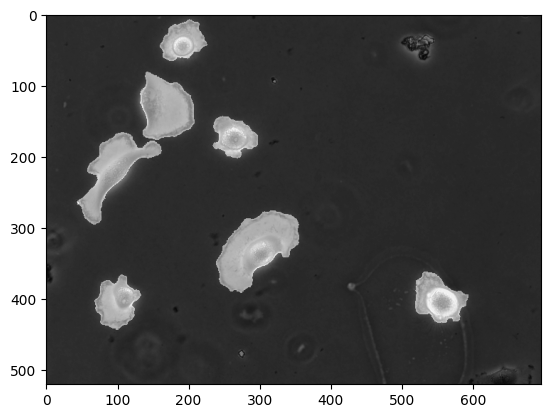

In [ ]:
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

In [10]:
from tensorflow.keras.models import Sequential

# Armo una red mínima fully convolutional con Atrous Convolutions

**En base al blog**
https://towardsdatascience.com/review-deeplabv3-atrous-convolution-semantic-segmentation-6d818bfd1d74

Las atrous convolutions aumentan el CP (campo perceptual) sin el costo de la extracción de features. Entonces se mantiene el padding en same y no se reduce la dimensionalidad.
Si no se hiciera esto, al profundizar con las diferentes capas de convolución perderiamos informacion espacial. De esta forma, no aumentamos los parametros pero aún asi tenemos un map de mayor tamaño que permite una mejor segmentación.


**En criollo:**
Se emplea las atrous convolutions que lo que hacen es tomar imagenes en diferentes escalas pero sin aumentar la cantidad de parametros. Por eso es que vemos empleado el dilation_rate. Esto sirve para mejorar la capacidad de la red para segmentar objetos de diferentes tamaños y aumentar el CP de la capa convolucional sin sacrificar la segmentación de pequeños objetos.

In [11]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


# Armo la red de preprocesamiento para hacer aumentación en la GPU que no tengo

get_preproc hace el data augmentation, mientras que el get_preproc_val recorta las imagenes para asegurar que tengan el mismo tamaño que las utilizadas durante el entrenamiento.

In [12]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

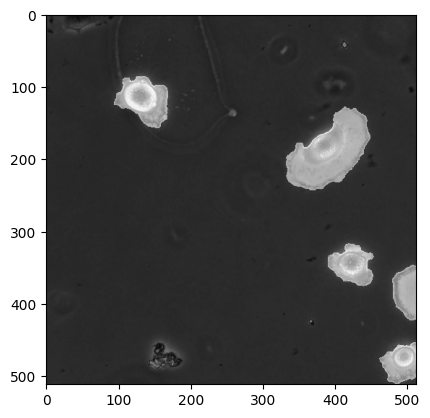

In [ ]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

se define el cálculo del coeficiente de DICE para evaluar la calidad al segmentar las imagenes

In [13]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

En el call se aplica red_segmentacion a las imágenes de entrada y returnea las masks de predicción. En el train_step se usa la red_preproc y en el test_step la red_preproc_val. Segun dice= true o no, calcula el coeficiente de dice y de ahi la loss; sino lo hace con el binary crossentropy como veniamos haciendo regularmente

In [14]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = True


    def call(self, inputs):
        #img_mask = self.red_preproc = red_preproc(inputs)
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)
            #print(K.mean(loss))

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #aux = self.red_preproc(data)
        mask_out = self.red_segmentacion(data[:,:,:,:1])
        #print(mask_out.shape)
        #print(data[:,:,:,1:2].numpy())
        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)
        return loss

    # property
    # def metrics(self):
    #     # We need to list our metrics here so the `reset_states()` can be
    #     # called automatically.
    #     return [self.loss_tracker]

In [ ]:
red_falopa = get_red_seg()

red_falopa es una fully convolutional. FALOPA es una sigla adoptada para FAcil de implementar, LOgros contundentes y PAreciera funcionar bien para su complejidad.

In [ ]:
red_falopa.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

In [ ]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa,preproc_val)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
len(x_val)

115

In [ ]:
model.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=30, validation_split = 0.5, verbose = 1)

Epoch 1/30
8/8 [==============================] - 77s 3s/step - loss: 0.8446 - val_loss: 0.9324
Epoch 2/30
8/8 [==============================] - 9s 1s/step - loss: 0.8304 - val_loss: 0.9313
Epoch 3/30
8/8 [==============================] - 9s 1s/step - loss: 0.8359 - val_loss: 0.9313
Epoch 4/30
8/8 [==============================] - 10s 1s/step - loss: 0.8340 - val_loss: 0.9308
Epoch 5/30
8/8 [==============================] - 9s 1s/step - loss: 0.8341 - val_loss: 0.9303
Epoch 6/30
8/8 [==============================] - 9s 1s/step - loss: 0.8322 - val_loss: 0.9295
Epoch 7/30
8/8 [==============================] - 9s 1s/step - loss: 0.8223 - val_loss: 0.9272
Epoch 8/30
8/8 [==============================] - 9s 1s/step - loss: 0.8193 - val_loss: 0.9113
Epoch 9/30
8/8 [==============================] - 9s 1s/step - loss: 0.7704 - val_loss: 0.8542
Epoch 10/30
8/8 [==============================] - 9s 1s/step - loss: 0.6733 - val_loss: 0.7430
Epoch 11/30
8/8 [==============================

In [ ]:
pred = red_falopa(x_val[0:1,:,:,0])
pred.shape

TensorShape([1, 520, 696, 1])

In [ ]:
pred.numpy().max()

1.0

In [ ]:
aux= preproc_val(x_val[0:1,:,:,:])
pred= red_falopa(aux[0:1,:,:,0])
val = x_val[0:1,:,:,1]
pred_casted = tf.cast((pred[0:1,:,:,0]>0.5), dtype=tf.float32)

print(x_val[0:1,:,:,1].shape)
print(pred_casted.shape)

print(dice_coef(aux[0:1,:,:,1], pred_casted))

(1, 520, 696)
(1, 512, 512)
tf.Tensor(0.803925, shape=(), dtype=float32)


DICE de 0.8 con 20 min de entrenamiento aproximadamente.

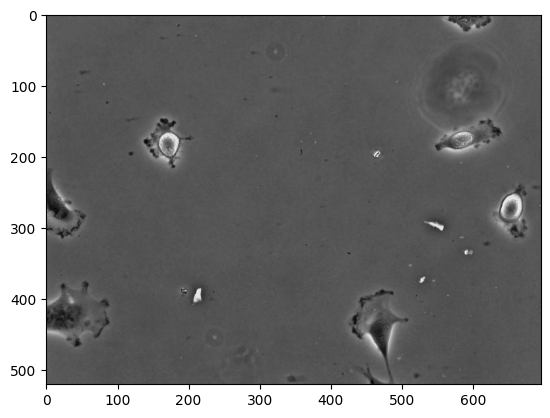

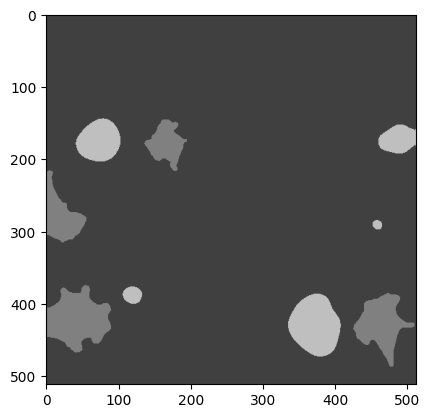

In [ ]:
plt.imshow(x_val[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

**Conclusión** La red entonces dio resultados de buena performance pero al no reducir dimensionalidad su complejidad computacional es alta.

In [15]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

**En base al blog:** https://arxiv.org/pdf/1505.04597.pdf
Similar a una CNN, aplicando sin padding varias convoluciones para la codificación, son downsampleadas y ampliados los numeros de canales. Una vez hecho esto, la decodificación viene dada por un upsampleo y una reducción de los números de canales. Se aplica un corte del map generado durante los downsampleos para compensar la pérdida en los bordes. Al hacerse de esta forma directa, y sin skip-conecction, podemos entonces tener una mejor definición para objetos pequeños como grandes. Una vez hecho esto, se emplea una capa más para la asignación correspondiente de características.


(**No existe tal versión criolla, se considera apropiada la del blog**)

**Unet vs Atrous** puede requerir más tiempo de entrenamiento a diferencia de FCN para alcanzar una buena precisión. Unet emplea conexiones directas entre la parte de codificación y decodificación, en cambio FCN solo capas convolucionales. FCN tiene un enfoque más global y Unet es más detallista en cuanto a objetos. Unet puede necesitar menos datos de entrenamiento.

In [ ]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [ ]:
from keras import backend as K

K.clear_session()

In [ ]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [ ]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 55s 3s/step - loss: 0.8435 - val_loss: 0.9313
Epoch 2/100
8/8 [==============================] - 12s 2s/step - loss: 0.8350 - val_loss: 0.9290
Epoch 3/100
8/8 [==============================] - 12s 2s/step - loss: 0.8217 - val_loss: 0.9293
Epoch 4/100
8/8 [==============================] - 12s 2s/step - loss: 0.8206 - val_loss: 0.9277
Epoch 5/100
8/8 [==============================] - 15s 2s/step - loss: 0.8272 - val_loss: 0.9268
Epoch 6/100
8/8 [==============================] - 12s 2s/step - loss: 0.8228 - val_loss: 0.9233
Epoch 7/100
8/8 [==============================] - 15s 2s/step - loss: 0.8074 - val_loss: 0.9047
Epoch 8/100
8/8 [==============================] - 12s 2s/step - loss: 0.7693 - val_loss: 0.8837
Epoch 9/100
8/8 [==============================] - 12s 2s/step - loss: 0.7355 - val_loss: 0.8479
Epoch 10/100
8/8 [==============================] - 12s 2s/step - loss: 0.5716 - val_loss: 0.7623
Epoch 11/100
8/8 [===========

In [ ]:
red_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 512, 512, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_23[0][0]']              
                                )                                                           

In [ ]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [ ]:
val = x_val[0:1,:,:,1]
pred_casted = tf.cast((pred[0:1,:,:,0]>0.5), dtype=tf.float32)

print(x_val[0:1,:,:,1].shape)
print(pred_casted.shape)

print(dice_coef(aux[0:1,:,:,1], pred_casted))

(1, 520, 696)
(1, 512, 512)
tf.Tensor(0.94027704, shape=(), dtype=float32)


DICE de 0.94 con 20 min entrenamiento aproximadamente

In [ ]:
pred.numpy().max()

1.0

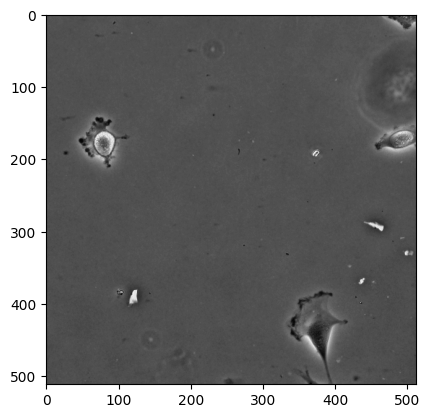

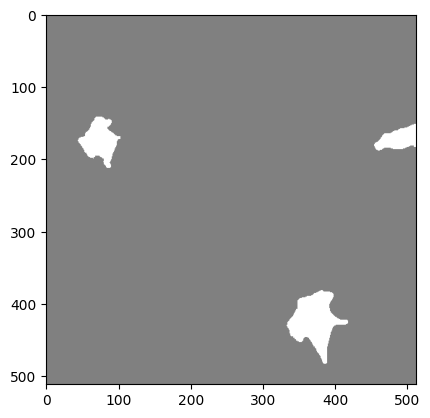

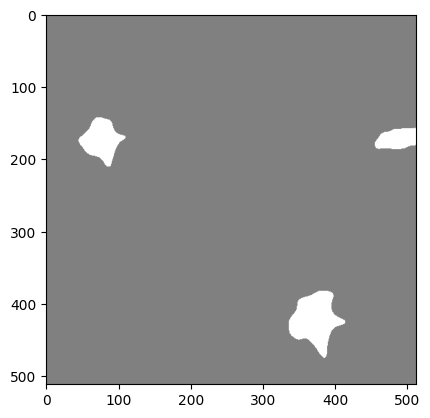

In [ ]:
plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray", alpha = 0.5)
plt.show()
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha = 0.5)
plt.show()


Pruebo que pasa si saco el >0.5 y el cast.

In [ ]:
dice_score_val = dice_coef(aux[0,:,:,1], pred[0,:,:,0])
print("Coeficiente de Dice (validación):", dice_score_val)

Coeficiente de Dice (validación): tf.Tensor(0.938841, shape=(), dtype=float32)


# Mejora al coef DICE

In [34]:
from keras import backend as K

# Realizar operaciones con Keras...

# Limpiar la sesión del backend
K.clear_session()


In [29]:
img_shape = (512, 512, 1)
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet2(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [35]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet2(
    img_shape,
    start_ch = 32,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet,preproc_unet_val)

In [36]:
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=16, epochs=50, validation_split = 0.5, verbose = 1)

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.8395

In [20]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
pred.shape

TensorShape([1, 512, 512, 1])

In [21]:
val = x_val[0:1,:,:,1]
pred_casted = tf.cast((pred[0:1,:,:,0]>0.5), dtype=tf.float32)

print(x_val[0:1,:,:,1].shape)
print(pred_casted.shape)

print(dice_coef(aux[0:1,:,:,1], pred_casted))

(1, 520, 696)
(1, 512, 512)
tf.Tensor(0.05616236, shape=(), dtype=float32)


Cambiando la salida de sigmoid a softmax, arruine la red. DICE de 0.057 con 50 epochs.
Cambiando los start_channels muere collab. Usando data augmentation muere collab. Unet > Collab